In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd
import folium
from shapely.geometry import Point

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio.mask import mask
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds
from rasterio.enums import Resampling

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import stackstac
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load

# Others
import os
from tqdm import tqdm

In [3]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_data_uhi_index_UHI2025-v2.csv")
ground_df.head()

Longitude   Latitude          datetime  UHI Index
0 -73.909167  40.813107  24-07-2021 15:53   1.030289
1 -73.909187  40.813045  24-07-2021 15:53   1.030289
2 -73.909215  40.812978  24-07-2021 15:53   1.023798
3 -73.909242  40.812908  24-07-2021 15:53   1.023798
4 -73.909257  40.812845  24-07-2021 15:53   1.021634

In [4]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
# Define the time window
time_window = "2021-06-01/2021-09-01"

In [5]:
# Define the bounding box coordinates
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

# Calculate the center of the bounding box
center = ((lower_left[0] + upper_right[0]) / 2, (lower_left[1] + upper_right[1]) / 2)

# Create a folium map centered at the middle of the bounding box
m = folium.Map(location=center, zoom_start=12)

# Draw the bounding box as a rectangle
folium.Rectangle(
    bounds=[lower_left, upper_right],
    color="blue",
    fill=True,
    fill_opacity=0.3
).add_to(m)

# Display the map
m

## SENTINEL 2 IMAGE PROCESSING

In [6]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [7]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 10


In [8]:
signed_items = [pc.sign(item).to_dict() for item in items]

In [9]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

In [10]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    # bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)

In [11]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 532MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 10)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

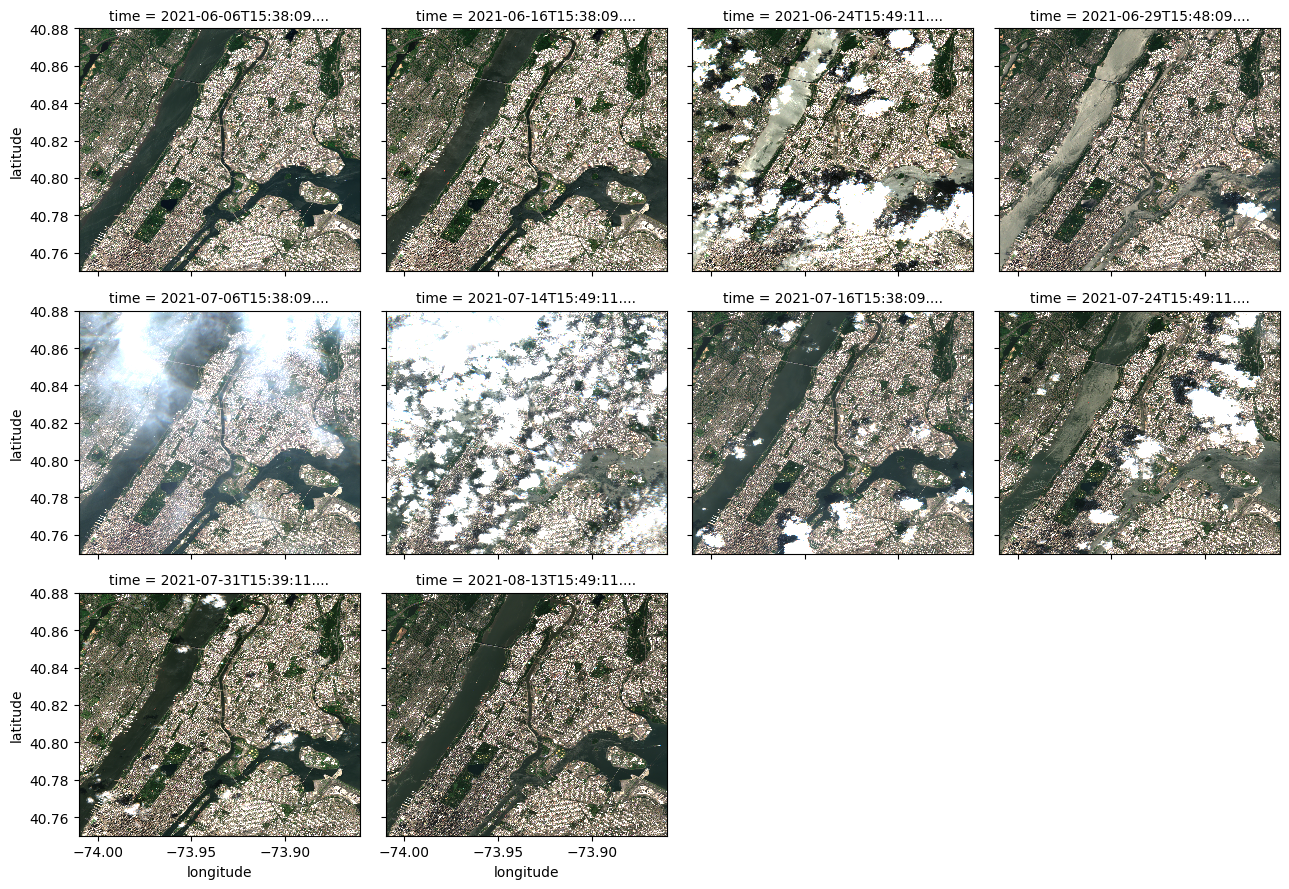

In [12]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

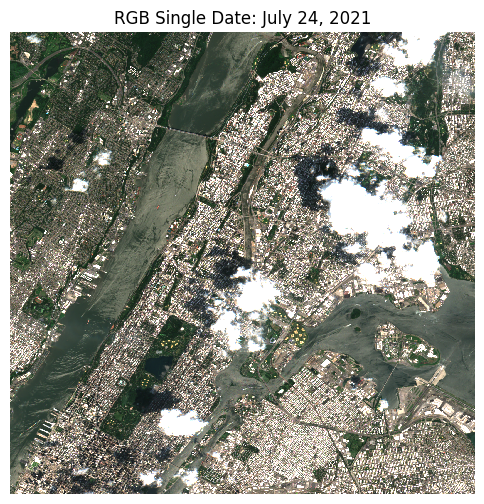

In [13]:
# Plot an RGB image for a single date
fig, ax = plt.subplots(figsize=(6,6))
plot_data.isel(time=7).plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Single Date: July 24, 2021")
ax.axis('off')
plt.show()

In [14]:
median = data.median(dim="time").compute()

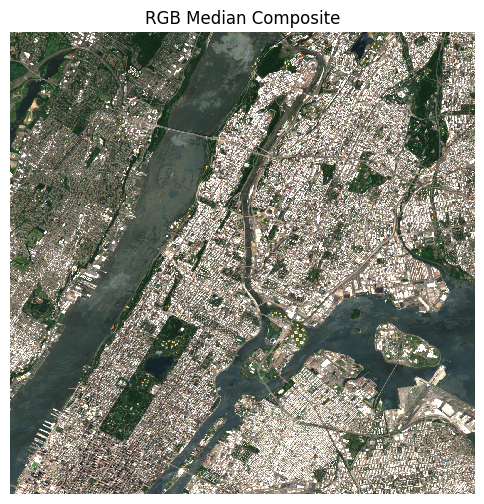

In [15]:
# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

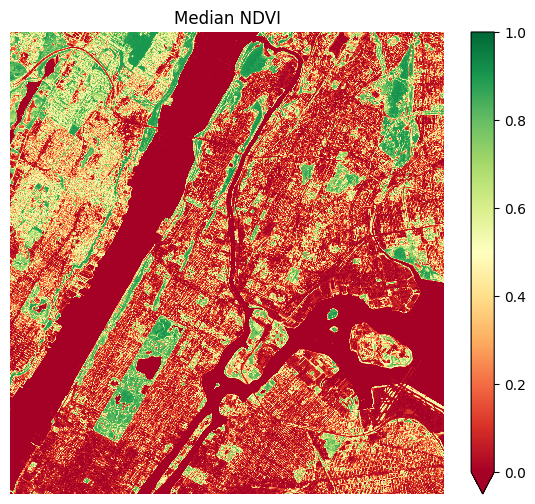

In [16]:
# Calculate NDVI for the median mosaic
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)
fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

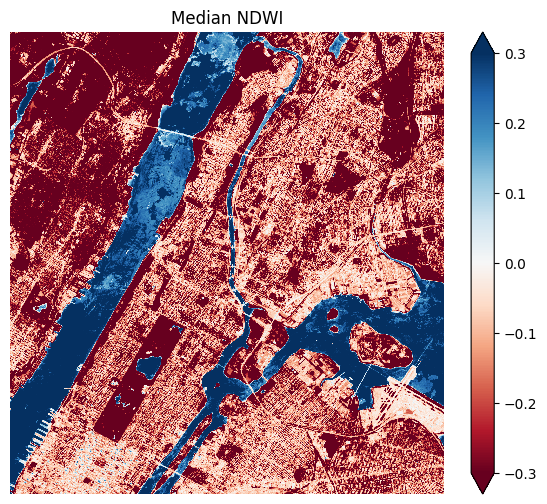

In [17]:
# Calculate NDWI for the median mosaic
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

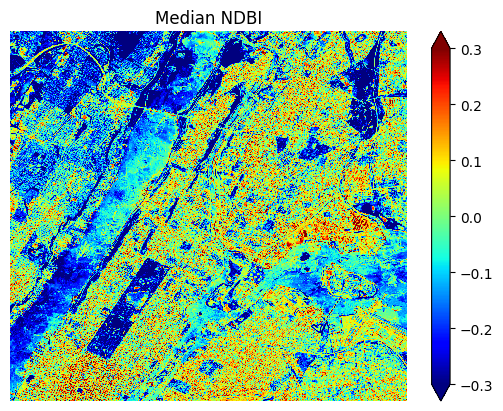

In [18]:
# Extract the SWIR (B11) and NIR (B08) bands from the median dataset
B11 = median['B11']
B08 = median['B08']

# Ensure the bands are aligned
B11, B08 = xr.align(B11, B08)

# Calculate NDBI
ndbi = (B11 - B08) / (B11 + B08)
ndbi.plot.imshow(vmin=-0.3, vmax=0.3, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

In [19]:
# # Assign CRS if not already present
# if not median.rio.crs:
#     median = median.rio.write_crs("EPSG:4326")  # Replace with your dataset's CRS

# # Export to TIFF
# median.rio.to_raster("median_output_20m.tiff")

In [20]:
import pandas as pd
import rioxarray as rxr
from pyproj import Transformer
from tqdm import tqdm

def map_specific_bands(tiff_path, csv_path, bands):
    """
    Extracts specified satellite band values from a GeoTIFF based on coordinates from a CSV file.

    Parameters:
    - tiff_path (str): Path to the GeoTIFF file.
    - csv_path (str): Path to the CSV file containing 'Latitude' and 'Longitude' columns.
    - bands (list of str): List of band names to extract (e.g., ['B01', 'B02', 'B03']).

    Returns:
    - pd.DataFrame: DataFrame containing the extracted band values for each coordinate.
    """
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path, masked=True)

    # Read the CSV file
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Transform coordinates to the GeoTIFF's CRS
    transformer = Transformer.from_crs("EPSG:4326", data.rio.crs, always_xy=True)
    transformed_coords = transformer.transform(longitudes, latitudes)

    # Initialize a dictionary to hold band values
    band_values = {band: [] for band in bands}

    # Extract band values for each coordinate
    for x, y in tqdm(zip(*transformed_coords), total=len(latitudes), desc="Mapping values"):
        for band in bands:
            band_index = int(band[1:])  # Convert 'B01' to 1, 'B02' to 2, etc.
            if band_index in data.band.values:
                value = data.sel(x=x, y=y, band=band_index, method="nearest").values
                band_values[band].append(value)
            else:
                band_values[band].append(None)  # Append None if the band is not available

    # Create a DataFrame with the band values
    result_df = pd.DataFrame(band_values)

    return result_df

In [21]:
tiff_path = 'median_output.tiff'
csv_path = 'Training_data_uhi_index_UHI2025-v2.csv'
# bands_to_extract = ['B02', 'B03', 'B04', 'B08', 'B11']
bands_to_extract = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12"]

final_data = map_specific_bands(tiff_path, csv_path, bands_to_extract)
final_data.head()

Mapping values: 100%|██████████| 11229/11229 [04:14<00:00, 44.04it/s]


B01     B02     B03     B04     B05     B06     B07     B08     B11   B12
0  841.5  1053.0  1155.0  1206.0  1481.5  1660.5  1721.0  1832.0  1495.5  None
1  841.5   646.0   823.0   777.0  1130.5  1883.0  2117.5  2241.0  1135.0  None
2  841.5   646.0   823.0   777.0  1130.5  1883.0  2117.5  2241.0  1135.0  None
3  841.5   625.0   766.0   741.5  1130.5  1883.0  2117.5  2200.0  1135.0  None
4  841.5   659.5   763.0   708.5  1077.5  1783.0  2042.0  2161.0  1207.5  None

In [22]:
# Calculate NDVI (Normalized Difference Vegetation Index)
final_data['NDVI_sentinel'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI_sentinel'] = final_data['NDVI_sentinel'].replace([np.inf, -np.inf], np.nan)

# # Calculate NDBI (Normalized Difference Built-up Index)
final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDWI (Normalized Difference Water Index)
final_data['NDWI'] = (final_data['B03'] - final_data['B08']) / (final_data['B03'] + final_data['B08'])
final_data['NDWI'] = final_data['NDWI'].replace([np.inf, -np.inf], np.nan)

In [23]:
# Replace NaNs resulting from division by zero
final_data.fillna(0, inplace=True)
print(final_data.shape)
final_data.head()

(11229, 13)


B01     B02     B03     B04     B05     B06     B07     B08     B11  B12  \
0  841.5  1053.0  1155.0  1206.0  1481.5  1660.5  1721.0  1832.0  1495.5    0   
1  841.5   646.0   823.0   777.0  1130.5  1883.0  2117.5  2241.0  1135.0    0   
2  841.5   646.0   823.0   777.0  1130.5  1883.0  2117.5  2241.0  1135.0    0   
3  841.5   625.0   766.0   741.5  1130.5  1883.0  2117.5  2200.0  1135.0    0   
4  841.5   659.5   763.0   708.5  1077.5  1783.0  2042.0  2161.0  1207.5    0   

   NDVI_sentinel      NDBI      NDWI  
0       0.206057 -0.101127 -0.226649  
1       0.485089 -0.327607 -0.462794  
2       0.485089 -0.327607 -0.462794  
3       0.495835 -0.319340 -0.483479  
4       0.506186 -0.283064 -0.478112

## LANDSAT LST PROCESSING

In [24]:
# Define the time window
# We will use a period of 3 months to search for data
time_window = "2021-06-01/2021-09-01"

In [25]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
)

In [26]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 8


In [27]:
signed_items = [pc.sign(item).to_dict() for item in items]

In [28]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [29]:
print(items[0].assets.keys())

dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])


In [30]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)

data2 = stac_load(
    items,
    bands=["lwir11", "trad", 'swir16', 'swir22', 'emis', 'drad', 'urad', 'atran'],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)

In [31]:
# Compute median composite for data1
median_composite1 = data1.median(dim="time", keep_attrs=True)

# Compute median composite for data2
median_composite2 = data2.median(dim="time", keep_attrs=True)

In [32]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(median_composite1)
display(median_composite2)

<xarray.Dataset> Size: 9MB
Dimensions:      (latitude: 484, longitude: 558)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
Data variables:
    red          (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    green        (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    blue         (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    nir08        (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>

<xarray.Dataset> Size: 17MB
Dimensions:      (latitude: 484, longitude: 558)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
Data variables:
    lwir11       (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    trad         (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    swir16       (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    swir22       (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    emis         (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    drad         (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    urad         (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>
    atran        (latitude, longitude) float64 2MB dask.array<chunksize=(484, 558), meta=np.ndarray>

In [33]:
# Persist the data in memory for faster operations
median_composite1 = median_composite1.persist()
median_composite2 = median_composite2.persist()

In [34]:
# Scale Factors for the RGB and NIR bands 
scale1 = 0.0000275 
offset1 = -0.2 
median_composite1 = median_composite1.astype(float) * scale1 + offset1

In [35]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802 
offset2 = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
median_composite2 = median_composite2.astype(float) * scale2 + offset2 - kelvin_celsius

In [36]:
# plot_data = data1[["red","green","blue"]].to_array()
# plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
# plt.show()

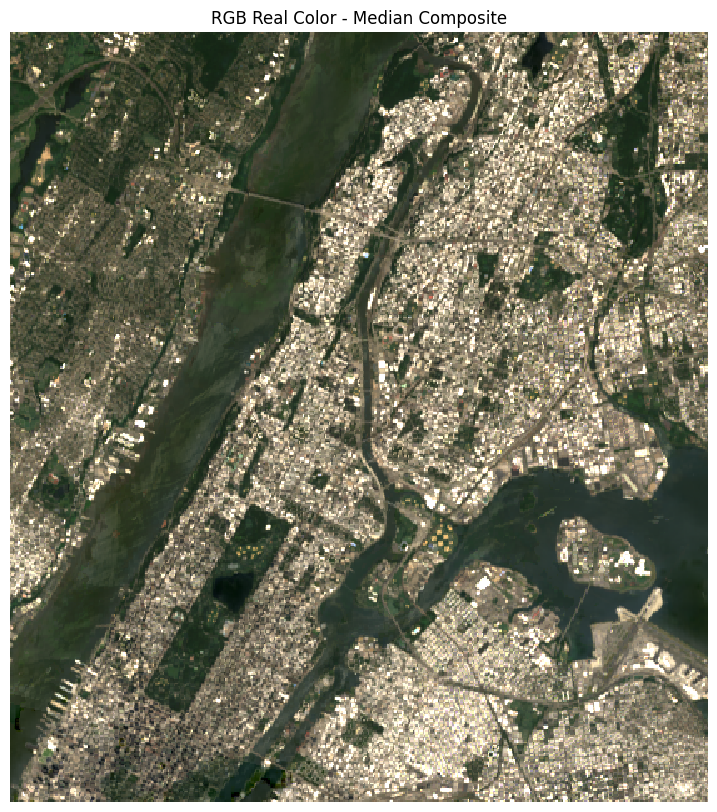

In [37]:
# Plot an RGB Real Color Image using the median composite
fig, ax = plt.subplots(figsize=(9,10))
median_composite1[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.25)
ax.set_title("RGB Real Color - Median Composite")
ax.axis('off')
plt.show()

In [38]:
# Calculate NDVI using the median composite
ndvi_data = (median_composite1.nir08 - median_composite1.red) / (median_composite1.nir08 + median_composite1.red)

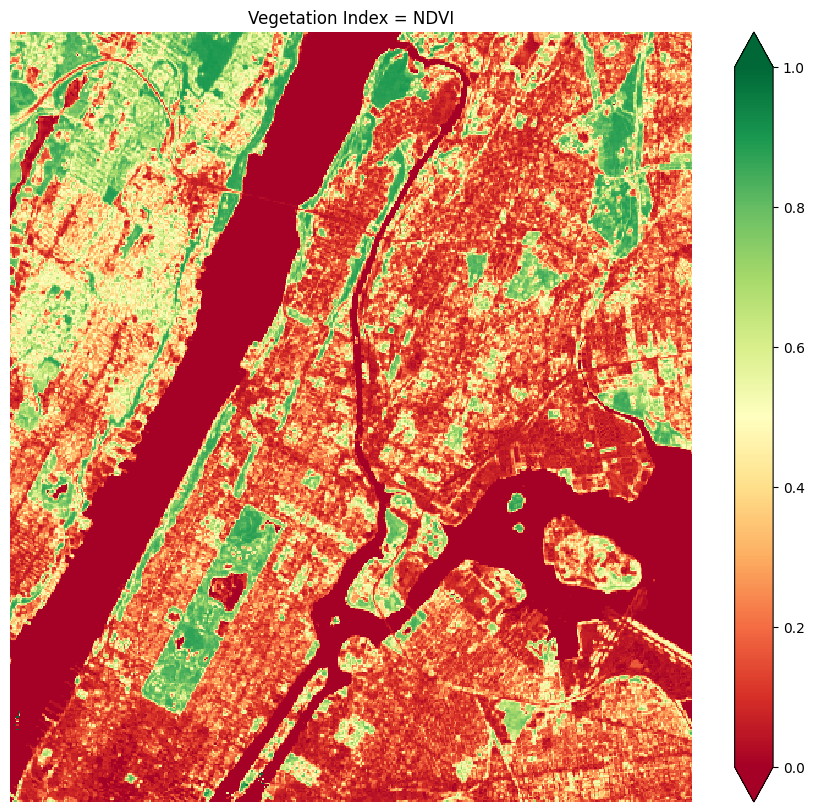

In [39]:
fig, ax = plt.subplots(figsize=(11,10))
ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

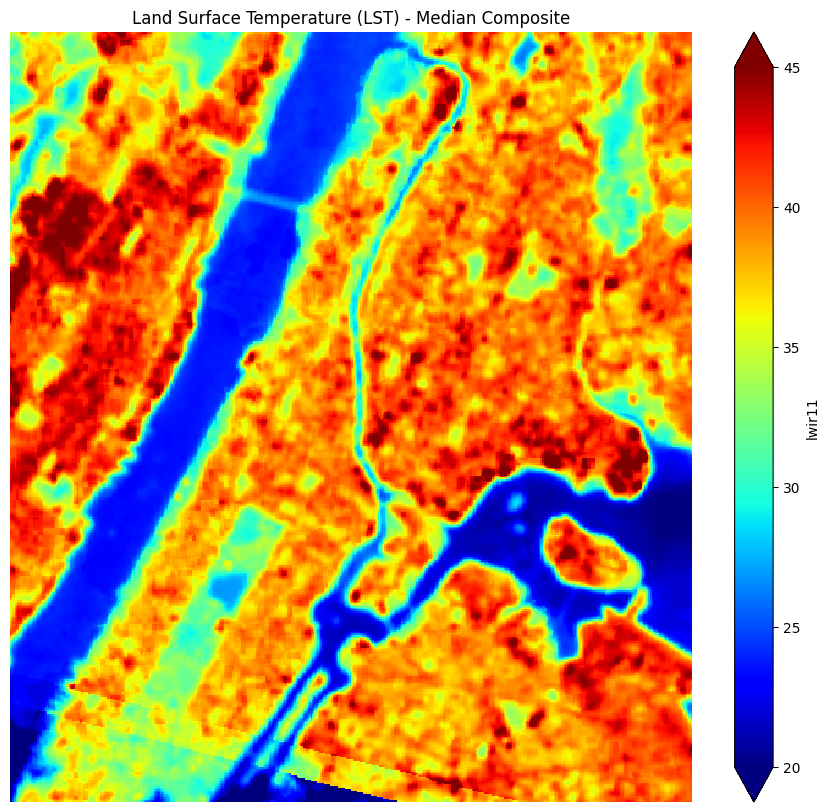

In [40]:
# Plot the median composite LST
fig, ax = plt.subplots(figsize=(11,10))
median_composite2.lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST) - Median Composite")
plt.axis('off')
plt.show()

In [41]:
median_composite1.rio.write_crs("EPSG:4326", inplace=True)
median_composite2.rio.write_crs("EPSG:4326", inplace=True)

# Export median_composite1 (Multiband TIFF)
# median_composite1.rio.to_raster("landsat_median_composite1.tif")

# Export median_composite2 (Single-band TIFF)
# median_composite2.rio.to_raster("landsat_median_composite2_v4.tif")

print("Export completed successfully!")

Export completed successfully!


In [42]:
import pandas as pd
import rioxarray as rxr
from pyproj import Transformer
from tqdm import tqdm

def map_specific_bands(tiff_path, csv_path, bands):
    """
    Extracts specified satellite band values from a GeoTIFF based on coordinates from a CSV file.

    Parameters:
    - tiff_path (str): Path to the GeoTIFF file.
    - csv_path (str): Path to the CSV file containing 'Latitude' and 'Longitude' columns.
    - bands (list of str): List of band names to extract (e.g., ['red', 'green', 'blue', 'nir08']).

    Returns:
    - pd.DataFrame: DataFrame containing the extracted band values for each coordinate.
    """
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path, masked=True)

    # Check if data has a band dimension (multi-band GeoTIFF)
    if "band" in data.dims:
        # If it's a numbered band dimension, create a mapping (band index → band name)
        band_mapping = {i+1: band for i, band in enumerate(bands)}
    else:
        band_mapping = {band: band for band in bands}  # Named variables

    # Read the CSV file
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Transform coordinates to the GeoTIFF's CRS
    transformer = Transformer.from_crs("EPSG:4326", data.rio.crs, always_xy=True)
    transformed_coords = transformer.transform(longitudes, latitudes)

    # Initialize a dictionary to hold band values
    band_values = {band: [] for band in bands}

    # Extract band values for each coordinate
    for x, y in tqdm(zip(*transformed_coords), total=len(latitudes), desc="Mapping values"):
        for key, band in band_mapping.items():
            if "band" in data.dims:  # If bands are stored in a 'band' dimension
                value = data.sel(x=x, y=y, band=key, method="nearest").values
            else:  # If bands are stored as separate variables
                value = data[band].sel(x=x, y=y, method="nearest").values
            band_values[band].append(value)

    # Create a DataFrame with the band values
    result_df = pd.DataFrame(band_values)

    # Add lat/lon back to DataFrame for reference
    result_df['Latitude'] = latitudes
    result_df['Longitude'] = longitudes

    return result_df

In [43]:
# Example for median_composite1 (RGB + NIR bands)
csv_path = 'Training_data_uhi_index_UHI2025-v2.csv'
bands_to_extract = ['red', 'green', 'blue', 'nir08']
landsat_df1 = map_specific_bands("landsat_median_composite1.tif", csv_path, bands_to_extract)

# Example for median_composite2 (Thermal band)
bands_to_extract = ["lwir11", "trad", 'swir16', 'swir22', 'emis', 'drad', 'urad', 'atran']
landsat_df2 = map_specific_bands("landsat_median_composite2_v4.tif", csv_path, bands_to_extract)

landsat_df1.head()

Mapping values: 100%|██████████| 11229/11229 [03:16<00:00, 57.17it/s]


red                green                 blue      nir08   Latitude  \
0  0.0711775  0.07354250000000001  0.05367375000000002  0.1953125  40.813107   
1  0.0711775  0.07354250000000001  0.05367375000000002  0.1953125  40.813045   
2  0.0711775  0.07354250000000001  0.05367375000000002  0.1953125  40.812978   
3  0.0711775  0.07354250000000001  0.05367375000000002  0.1953125  40.812908   
4  0.0837175  0.08686624999999998  0.06281749999999997  0.2159375  40.812845   

   Longitude  
0 -73.909167  
1 -73.909187  
2 -73.909215  
3 -73.909242  
4 -73.909257

In [44]:
landsat_df2.head()

lwir11                trad              swir16  \
0  39.92692307000004  -88.77178398999999  -82.70992551999998   
1  39.92692307000004  -88.77178398999999  -82.70992551999998   
2  39.92692307000004  -88.77178398999999  -82.70992551999998   
3  39.92692307000004  -88.77178398999999  -82.70992551999998   
4  39.55094086999998  -88.86919755999998  -78.74331330999996   

               swir22                emis                 drad  \
0  -88.17192147999998  -90.89608341999997  -119.07765831999998   
1  -88.17192147999998  -90.89608341999997  -119.07765831999998   
2  -88.17192147999998  -90.89608341999997  -119.07765831999998   
3  -88.17192147999998  -90.89608341999997  -119.07765831999998   
4  -85.49561181999997  -90.89608341999997  -119.07765831999998   

                  urad                atran   Latitude  Longitude  
0  -113.10295935999997  -103.07448867999997  40.813107 -73.909167  
1  -113.10295935999997  -103.07448867999997  40.813045 -73.909187  
2  -113.10295935999997  -103.07448867999997  40.812978 -73.909215  
3  -113.10295935999997  -103.07448867999997  40.812908 -73.909242  
4  -113.10295935999997  -103.07448867999997  40.812845 -73.909257

In [45]:
# Compute NDVI and add it to the dataframe
landsat_df1["NDVI_landsat"] = (landsat_df1["nir08"] - landsat_df1["red"]) / (landsat_df1["nir08"] + landsat_df1["red"])

# NDWI (Normalized Difference Water Index)
landsat_df1["NDWI_landsat"] = (landsat_df1["nir08"] - landsat_df1["green"]) / (landsat_df1["nir08"] + landsat_df1["green"])

# VARI (Visible Atmospherically Resistant Index)
landsat_df1["VARI_landsat"] = (landsat_df1["green"] - landsat_df1["red"]) / (landsat_df1["green"] + landsat_df1["red"] - landsat_df1["blue"])

landsat_df1.head()

red                green                 blue      nir08   Latitude  \
0  0.0711775  0.07354250000000001  0.05367375000000002  0.1953125  40.813107   
1  0.0711775  0.07354250000000001  0.05367375000000002  0.1953125  40.813045   
2  0.0711775  0.07354250000000001  0.05367375000000002  0.1953125  40.812978   
3  0.0711775  0.07354250000000001  0.05367375000000002  0.1953125  40.812908   
4  0.0837175  0.08686624999999998  0.06281749999999997  0.2159375  40.812845   

   Longitude NDVI_landsat NDWI_landsat VARI_landsat  
0 -73.909167     0.465815     0.452921     0.025976  
1 -73.909187     0.465815     0.452921     0.025976  
2 -73.909215     0.465815     0.452921     0.025976  
3 -73.909242     0.465815     0.452921     0.025976  
4 -73.909257     0.441241     0.426254     0.029218

In [46]:
# Drop Latitude and Longitude from landsat_df1 (RGB + NIR + NDVI)
landsat_df1 = landsat_df1.drop(columns=["Latitude", "Longitude"])

# Drop Latitude and Longitude from landsat_df2 (Thermal band)
landsat_df2 = landsat_df2.drop(columns=["Latitude", "Longitude"])

In [47]:
landsat_df1.shape, landsat_df2.shape

((11229, 7), (11229, 8))

In [48]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [49]:
# Combining ground data and final data into a single dataset.
print(ground_df.shape)
uhi_data = combine_two_datasets(ground_df,final_data)
print(uhi_data.shape)
uhi_data = combine_two_datasets(uhi_data,landsat_df1)
uhi_data = combine_two_datasets(uhi_data,landsat_df2)
print(uhi_data.shape)
uhi_data.head()

(11229, 4)
(11229, 17)
(11229, 32)


Longitude   Latitude          datetime  UHI Index    B01     B02     B03  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289  841.5  1053.0  1155.0   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289  841.5   646.0   823.0   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798  841.5   646.0   823.0   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798  841.5   625.0   766.0   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634  841.5   659.5   763.0   

      B04     B05     B06  ... NDWI_landsat VARI_landsat             lwir11  \
0  1206.0  1481.5  1660.5  ...     0.452921     0.025976  39.92692307000004   
1   777.0  1130.5  1883.0  ...     0.452921     0.025976  39.92692307000004   
2   777.0  1130.5  1883.0  ...     0.452921     0.025976  39.92692307000004   
3   741.5  1130.5  1883.0  ...     0.452921     0.025976  39.92692307000004   
4   708.5  1077.5  1783.0  ...     0.426254     0.029218  39.55094086999998   

                 trad              swir16              swir22  \
0  -88.77178398999999  -82.70992551999998  -88.17192147999998   
1  -88.77178398999999  -82.70992551999998  -88.17192147999998   
2  -88.77178398999999  -82.70992551999998  -88.17192147999998   
3  -88.77178398999999  -82.70992551999998  -88.17192147999998   
4  -88.86919755999998  -78.74331330999996  -85.49561181999997   

                 emis                 drad                 urad  \
0  -90.89608341999997  -119.07765831999998  -113.10295935999997   
1  -90.89608341999997  -119.07765831999998  -113.10295935999997   
2  -90.89608341999997  -119.07765831999998  -113.10295935999997   
3  -90.89608341999997  -119.07765831999998  -113.10295935999997   
4  -90.89608341999997  -119.07765831999998  -113.10295935999997   

                 atran  
0  -103.07448867999997  
1  -103.07448867999997  
2  -103.07448867999997  
3  -103.07448867999997  
4  -103.07448867999997  

[5 rows x 32 columns]

In [50]:
uhi_data = uhi_data.drop(['datetime', 'Longitude', 'Latitude'], axis=1, errors='ignore')
uhi_data.head()

UHI Index    B01     B02     B03     B04     B05     B06     B07     B08  \
0   1.030289  841.5  1053.0  1155.0  1206.0  1481.5  1660.5  1721.0  1832.0   
1   1.030289  841.5   646.0   823.0   777.0  1130.5  1883.0  2117.5  2241.0   
2   1.023798  841.5   646.0   823.0   777.0  1130.5  1883.0  2117.5  2241.0   
3   1.023798  841.5   625.0   766.0   741.5  1130.5  1883.0  2117.5  2200.0   
4   1.021634  841.5   659.5   763.0   708.5  1077.5  1783.0  2042.0  2161.0   

      B11  ...  NDWI_landsat  VARI_landsat             lwir11  \
0  1495.5  ...      0.452921      0.025976  39.92692307000004   
1  1135.0  ...      0.452921      0.025976  39.92692307000004   
2  1135.0  ...      0.452921      0.025976  39.92692307000004   
3  1135.0  ...      0.452921      0.025976  39.92692307000004   
4  1207.5  ...      0.426254      0.029218  39.55094086999998   

                 trad              swir16              swir22  \
0  -88.77178398999999  -82.70992551999998  -88.17192147999998   
1  -88.77178398999999  -82.70992551999998  -88.17192147999998   
2  -88.77178398999999  -82.70992551999998  -88.17192147999998   
3  -88.77178398999999  -82.70992551999998  -88.17192147999998   
4  -88.86919755999998  -78.74331330999996  -85.49561181999997   

                 emis                 drad                 urad  \
0  -90.89608341999997  -119.07765831999998  -113.10295935999997   
1  -90.89608341999997  -119.07765831999998  -113.10295935999997   
2  -90.89608341999997  -119.07765831999998  -113.10295935999997   
3  -90.89608341999997  -119.07765831999998  -113.10295935999997   
4  -90.89608341999997  -119.07765831999998  -113.10295935999997   

                 atran  
0  -103.07448867999997  
1  -103.07448867999997  
2  -103.07448867999997  
3  -103.07448867999997  
4  -103.07448867999997  

[5 rows x 29 columns]

In [51]:
uhi_data.columns, uhi_data.shape

(Index(['UHI Index', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
        'B11', 'B12', 'NDVI_sentinel', 'NDBI', 'NDWI', 'red', 'green', 'blue',
        'nir08', 'NDVI_landsat', 'NDWI_landsat', 'VARI_landsat', 'lwir11',
        'trad', 'swir16', 'swir22', 'emis', 'drad', 'urad', 'atran'],
       dtype='object'),
 (11229, 29))

In [52]:
# Split the data into features (X) and target (y), and then into training and testing sets

# X = uhi_data.drop(columns=['UHI Index']).values
X = uhi_data[['red', 'green',
        'blue', 'nir08', 'NDVI_landsat', 'NDWI_landsat', 'VARI_landsat','lwir11', 'trad', 'swir16', 'swir22', 'emis', 'drad', 
        'urad', 'atran']].values
y = uhi_data ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=100)

In [53]:
# X.head()

In [54]:
from sklearn.preprocessing import MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [56]:
# Initialize the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)

# Train the Model
print("Training the Model...🚀")
rf_model.fit(X_train_scaled, y_train)

Training the Model...🚀


RandomForestRegressor(random_state=123)

In [57]:
# Predictions
y_pred = rf_model.predict(X_test_scaled)

In [58]:
# Model Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"📌 R² Score: {r2:.4f}")
print(f"📌 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📌 Root Mean Squared Error (RMSE): {rmse:.4f}")

📌 R² Score: 0.9258
📌 Mean Absolute Error (MAE): 0.0030
📌 Root Mean Squared Error (RMSE): 0.0045


In [63]:
# Split the data into features (X) and target (y), and then into training and testing sets

# X = uhi_data.drop(columns=['UHI Index'])
X = uhi_data[['red', 'green',
        'blue', 'nir08', 'NDVI_landsat', 'NDWI_landsat', 'VARI_landsat','lwir11', 'trad', 'swir16', 
        'swir22', 'emis', 'drad', 'urad', 'atran']]
y = uhi_data ['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=100)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

# Function to perform hyperparameter tuning using Grid Search
def tune_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Define hyperparameter grids for tuning
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Tune and evaluate XGBoost Model
xgb_model = tune_model(XGBRegressor(), xgb_param_grid, X_train_scaled, y_train)
xgb_mae, xgb_rmse, xgb_r2 = evaluate_model(xgb_model, X_test_scaled, y_test)
print(f"XGBoost MAE: {xgb_mae:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R² Score: {xgb_r2:.4f}")

# Feature Importance Analysis (optional)
xgb_feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("XGBoost Feature Importances:")
print(xgb_feature_importances)

XGBoost MAE: 0.0031
XGBoost RMSE: 0.0045
XGBoost R² Score: 0.9277
XGBoost Feature Importances:
atran           0.469143
urad            0.130368
emis            0.071884
trad            0.061504
drad            0.046454
NDVI_landsat    0.033818
lwir11          0.030175
NDWI_landsat    0.026569
VARI_landsat    0.024255
swir22          0.023478
nir08           0.022076
swir16          0.020712
blue            0.017421
green           0.012492
red             0.009650
dtype: float32


In [65]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = XGBRegressor(random_state=123)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=2)
print("🔥 Hyperparameter Tuning in Progress...⏳")
grid_search.fit(X_train_scaled, y_train)
# Best Parameters
print("✅ Best Hyperparameters:", grid_search.best_params_)

# Best Model
best_xgb_model = grid_search.best_estimator_

# Predict
y_pred = best_xgb_model.predict(X_test_scaled)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"📌 Best R² Score: {r2:.4f}")
print(f"📌 Best MAE: {mae:.4f}")
print(f"📌 Best RMSE: {rmse:.4f}")

🔥 Hyperparameter Tuning in Progress...⏳
Fitting 5 folds for each of 192 candidates, totalling 960 fits
✅ Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}
📌 Best R² Score: 0.9310
📌 Best MAE: 0.0028
📌 Best RMSE: 0.0044


In [66]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template_UHI2025-v2.csv')
test_file.head()

Longitude   Latitude  UHI Index
0 -73.971665  40.788763        NaN
1 -73.971928  40.788875        NaN
2 -73.967080  40.789080        NaN
3 -73.972550  40.789082        NaN
4 -73.969697  40.787953        NaN

In [67]:
tiff_path = 'median_output.tiff'
csv_path = 'Submission_template_UHI2025-v2.csv'
# bands_to_extract = ['B01', 'B02', 'B03', 'B04', 'B06', 'B08', 'B11']
bands_to_extract = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12"]

val_data = map_specific_bands(tiff_path, csv_path, bands_to_extract)
val_data.head()

Mapping values: 100%|██████████| 1040/1040 [00:24<00:00, 42.99it/s]


B01     B02     B03     B04     B05     B06     B07     B08     B11  \
0   805.5   511.5   609.5   523.5  1078.5  2243.0  2596.0  2367.0  2702.0   
1  1214.5   728.0   849.5   733.5  1288.0  2617.0  2961.5  3073.0  3023.5   
2  1061.0   886.5  1018.5  1155.0  1048.5  1457.0  1622.5  1462.0  1757.0   
3  1191.0  1014.5  1030.0  1189.0  1918.5  1958.5  2023.0  1571.0  2056.0   
4  1082.0  1251.0  1390.0  1293.5  1310.0  2280.0  2599.5  2936.0  2657.5   

      B12   Latitude  Longitude  
0  1727.0  40.788763 -73.971665  
1  2116.5  40.788875 -73.971928  
2  1646.0  40.789080 -73.967080  
3  2393.5  40.789082 -73.972550  
4  2118.5  40.787953 -73.969697

In [68]:
# Calculate NDVI (Normalized Difference Vegetation Index)
val_data['NDVI_sentinel'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI_sentinel'] = val_data['NDVI_sentinel'].replace([np.inf, -np.inf], np.nan)

# # Calculate NDBI (Normalized Difference Built-up Index)
val_data['NDBI'] = (val_data['B11'] - val_data['B08']) / (val_data['B11'] + val_data['B08'])
val_data['NDBI'] = val_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDWI (Normalized Difference Water Index)
val_data['NDWI'] = (val_data['B03'] - val_data['B08']) / (val_data['B03'] + val_data['B08'])
val_data['NDWI'] = val_data['NDWI'].replace([np.inf, -np.inf], np.nan)

val_data.head()

B01     B02     B03     B04     B05     B06     B07     B08     B11  \
0   805.5   511.5   609.5   523.5  1078.5  2243.0  2596.0  2367.0  2702.0   
1  1214.5   728.0   849.5   733.5  1288.0  2617.0  2961.5  3073.0  3023.5   
2  1061.0   886.5  1018.5  1155.0  1048.5  1457.0  1622.5  1462.0  1757.0   
3  1191.0  1014.5  1030.0  1189.0  1918.5  1958.5  2023.0  1571.0  2056.0   
4  1082.0  1251.0  1390.0  1293.5  1310.0  2280.0  2599.5  2936.0  2657.5   

      B12   Latitude  Longitude  NDVI_sentinel      NDBI      NDWI  
0  1727.0  40.788763 -73.971665       0.637779  0.066088 -0.590459  
1  2116.5  40.788875 -73.971928       0.614607 -0.008119 -0.566858  
2  1646.0  40.789080 -73.967080       0.117310  0.091643 -0.178795  
3  2393.5  40.789082 -73.972550       0.138406  0.133719 -0.207997  
4  2118.5  40.787953 -73.969697       0.388344 -0.049790 -0.357374

In [69]:
# Example for median_composite1 (RGB + NIR bands)
# csv_path = 'Training_data_uhi_index_UHI2025-v2.csv'
csv_path = 'Submission_template_UHI2025-v2.csv'
bands_to_extract = ['red', 'green', 'blue', 'nir08']
landsat_df1 = map_specific_bands("landsat_median_composite1.tif", csv_path, bands_to_extract)

# Example for median_composite2 (Thermal band)
bands_to_extract = ['lwir11', "trad", 'swir16', 'swir22', 'emis', 'drad', 'urad', 'atran']
landsat_df2 = map_specific_bands("landsat_median_composite2_v4.tif", csv_path, bands_to_extract)

landsat_df1.head()

Mapping values: 100%|██████████| 1040/1040 [00:13<00:00, 78.65it/s]


red                green                 blue  \
0             0.060975            0.0712875            0.0506625   
1             0.060975            0.0712875            0.0506625   
2  0.11568624999999999  0.10816500000000001  0.08688000000000001   
3            0.1731475           0.15435125           0.13185625   
4             0.127195            0.1205675  0.11528749999999999   

                 nir08   Latitude  Longitude  
0  0.23727750000000003  40.788763 -73.971665  
1  0.23727750000000003  40.788875 -73.971928  
2              0.14298  40.789080 -73.967080  
3  0.23246499999999998  40.789082 -73.972550  
4  0.24270875000000003  40.787953 -73.969697

In [70]:
# Compute NDVI and add it to the dataframe
landsat_df1["NDVI_landsat"] = (landsat_df1["nir08"] - landsat_df1["red"]) / (landsat_df1["nir08"] + landsat_df1["red"])

# NDWI (Normalized Difference Water Index)
landsat_df1["NDWI_landsat"] = (landsat_df1["nir08"] - landsat_df1["green"]) / (landsat_df1["nir08"] + landsat_df1["green"])

# VARI (Visible Atmospherically Resistant Index)
landsat_df1["VARI_landsat"] = (landsat_df1["green"] - landsat_df1["red"]) / (landsat_df1["green"] + landsat_df1["red"] - landsat_df1["blue"])

In [71]:
landsat_df1.shape, landsat_df2.shape

((1040, 9), (1040, 10))

In [72]:
# Drop Latitude and Longitude from landsat_df1 (RGB + NIR + NDVI)
landsat_df1 = landsat_df1.drop(columns=["Latitude", "Longitude"])

# Drop Latitude and Longitude from landsat_df2 (Thermal band)
landsat_df2 = landsat_df2.drop(columns=["Latitude", "Longitude"])

In [73]:
landsat_df1.head()

red                green                 blue  \
0             0.060975            0.0712875            0.0506625   
1             0.060975            0.0712875            0.0506625   
2  0.11568624999999999  0.10816500000000001  0.08688000000000001   
3            0.1731475           0.15435125           0.13185625   
4             0.127195            0.1205675  0.11528749999999999   

                 nir08 NDVI_landsat NDWI_landsat VARI_landsat  
0  0.23727750000000003     0.591118     0.537942     0.126379  
1  0.23727750000000003     0.591118     0.537942     0.126379  
2              0.14298     0.105517     0.138625    -0.054911  
3  0.23246499999999998     0.146242      0.20194    -0.096074  
4  0.24270875000000003     0.312281     0.336221    -0.050028

In [74]:
landsat_df2.head()

lwir11                trad              swir16  \
0   38.14613465000002  -89.80402602999999  -81.55121673999997   
1   38.14613465000002  -89.80402602999999  -81.55121673999997   
2   37.08142142000003  -90.02790633999999  -81.11371017999997   
3  38.549461010000016  -89.71003047999997  -70.30934895999997   
4   36.38243633000002  -90.06550455999997  -73.45563636999998   

               swir22                emis                 drad  \
0  -88.52397753999998  -91.48398285999997  -119.11183851999996   
1  -88.52397753999998  -91.48398285999997  -119.11183851999996   
2  -82.50484431999996  -90.79866984999998  -119.11183851999996   
3  -74.49642345999999  -91.48398285999997  -119.11183851999996   
4  -78.44936358999996  -90.87557529999998  -119.11183851999996   

                  urad                atran  
0  -113.19182787999998  -102.97536609999997  
1  -113.19182787999998  -102.97536609999997  
2  -113.18840985999998  -102.97878411999997  
3  -113.19182787999998  -102.97536609999997  
4  -113.19182787999998  -102.97536609999997

In [75]:
val_data = combine_two_datasets(val_data, landsat_df1)
print(val_data.shape)

(1040, 22)


In [76]:
val_data = combine_two_datasets(val_data, landsat_df2)
print(val_data.shape)

(1040, 30)


In [77]:
val_data.head()

B01     B02     B03     B04     B05     B06     B07     B08     B11  \
0   805.5   511.5   609.5   523.5  1078.5  2243.0  2596.0  2367.0  2702.0   
1  1214.5   728.0   849.5   733.5  1288.0  2617.0  2961.5  3073.0  3023.5   
2  1061.0   886.5  1018.5  1155.0  1048.5  1457.0  1622.5  1462.0  1757.0   
3  1191.0  1014.5  1030.0  1189.0  1918.5  1958.5  2023.0  1571.0  2056.0   
4  1082.0  1251.0  1390.0  1293.5  1310.0  2280.0  2599.5  2936.0  2657.5   

      B12  ...  NDWI_landsat  VARI_landsat              lwir11  \
0  1727.0  ...      0.537942      0.126379   38.14613465000002   
1  2116.5  ...      0.537942      0.126379   38.14613465000002   
2  1646.0  ...      0.138625     -0.054911   37.08142142000003   
3  2393.5  ...       0.20194     -0.096074  38.549461010000016   
4  2118.5  ...      0.336221     -0.050028   36.38243633000002   

                 trad              swir16              swir22  \
0  -89.80402602999999  -81.55121673999997  -88.52397753999998   
1  -89.80402602999999  -81.55121673999997  -88.52397753999998   
2  -90.02790633999999  -81.11371017999997  -82.50484431999996   
3  -89.71003047999997  -70.30934895999997  -74.49642345999999   
4  -90.06550455999997  -73.45563636999998  -78.44936358999996   

                 emis                 drad                 urad  \
0  -91.48398285999997  -119.11183851999996  -113.19182787999998   
1  -91.48398285999997  -119.11183851999996  -113.19182787999998   
2  -90.79866984999998  -119.11183851999996  -113.18840985999998   
3  -91.48398285999997  -119.11183851999996  -113.19182787999998   
4  -90.87557529999998  -119.11183851999996  -113.19182787999998   

                 atran  
0  -102.97536609999997  
1  -102.97536609999997  
2  -102.97878411999997  
3  -102.97536609999997  
4  -102.97536609999997  

[5 rows x 30 columns]

In [ ]:
# # Combining ground data and final data into a single dataset.
# print(ground_df.shape)
# uhi_data = combine_two_datasets(ground_df,final_data)
# print(uhi_data.shape)
# uhi_data = combine_two_datasets(uhi_data,landsat_df1)
# uhi_data = combine_two_datasets(uhi_data,landsat_df2)
# print(uhi_data.shape)
# uhi_data.head()

In [78]:
val_data.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12',
       'Latitude', 'Longitude', 'NDVI_sentinel', 'NDBI', 'NDWI', 'red',
       'green', 'blue', 'nir08', 'NDVI_landsat', 'NDWI_landsat',
       'VARI_landsat', 'lwir11', 'trad', 'swir16', 'swir22', 'emis', 'drad',
       'urad', 'atran'],
      dtype='object')

In [79]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:, ['red',
       'green','blue', 'nir08', 'NDVI_landsat', 'NDWI_landsat', 'VARI_landsat','lwir11', 'trad', 'swir16', 'swir22', 'emis', 'drad',
       'urad', 'atran']]
submission_val_data.head()

red                green                 blue  \
0             0.060975            0.0712875            0.0506625   
1             0.060975            0.0712875            0.0506625   
2  0.11568624999999999  0.10816500000000001  0.08688000000000001   
3            0.1731475           0.15435125           0.13185625   
4             0.127195            0.1205675  0.11528749999999999   

                 nir08 NDVI_landsat NDWI_landsat VARI_landsat  \
0  0.23727750000000003     0.591118     0.537942     0.126379   
1  0.23727750000000003     0.591118     0.537942     0.126379   
2              0.14298     0.105517     0.138625    -0.054911   
3  0.23246499999999998     0.146242      0.20194    -0.096074   
4  0.24270875000000003     0.312281     0.336221    -0.050028   

               lwir11                trad              swir16  \
0   38.14613465000002  -89.80402602999999  -81.55121673999997   
1   38.14613465000002  -89.80402602999999  -81.55121673999997   
2   37.08142142000003  -90.02790633999999  -81.11371017999997   
3  38.549461010000016  -89.71003047999997  -70.30934895999997   
4   36.38243633000002  -90.06550455999997  -73.45563636999998   

               swir22                emis                 drad  \
0  -88.52397753999998  -91.48398285999997  -119.11183851999996   
1  -88.52397753999998  -91.48398285999997  -119.11183851999996   
2  -82.50484431999996  -90.79866984999998  -119.11183851999996   
3  -74.49642345999999  -91.48398285999997  -119.11183851999996   
4  -78.44936358999996  -90.87557529999998  -119.11183851999996   

                  urad                atran  
0  -113.19182787999998  -102.97536609999997  
1  -113.19182787999998  -102.97536609999997  
2  -113.18840985999998  -102.97878411999997  
3  -113.19182787999998  -102.97536609999997  
4  -113.19182787999998  -102.97536609999997

In [80]:
submission_val_data.shape, submission_val_data.columns

((1040, 15),
 Index(['red', 'green', 'blue', 'nir08', 'NDVI_landsat', 'NDWI_landsat',
        'VARI_landsat', 'lwir11', 'trad', 'swir16', 'swir22', 'emis', 'drad',
        'urad', 'atran'],
       dtype='object'))

In [81]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = scaler.transform(submission_val_data)

In [82]:
#Making predictions
final_predictions = best_xgb_model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [83]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [84]:
#Displaying the sample submission dataframe
submission_df.head()

Longitude   Latitude  UHI Index
0 -73.971665  40.788763   0.964857
1 -73.971928  40.788875   0.964857
2 -73.967080  40.789080   0.975179
3 -73.972550  40.789082   0.970930
4 -73.969697  40.787953   0.959195

In [85]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission_v5.csv",index = False)

In [ ]:
# Todo export landsat data 1 and 2 medians 
# extract bands 
# calculate indexes
# map to training file 
# retrain 